train120m-180m, train:valid 90:10(shuffle)  
num_boost_round = 10000, early_stopping_rounds = 50  
特徴量削除

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def do_next_Click(df,agg_suffix='nextClick', agg_type='float32'):
    with timer("Adding next click times"):
    
        print(f">> \nExtracting {agg_suffix} time calculation features...\n")

        GROUP_BY_NEXT_CLICKS = [

        # V1
        # {'groupby': ['ip']},
        # {'groupby': ['ip', 'app']},
        # {'groupby': ['ip', 'channel']},
        # {'groupby': ['ip', 'os']},

        # V3
        {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
        {'groupby': ['ip', 'os', 'device']},
        {'groupby': ['ip', 'os', 'device', 'app']},
    #     {'groupby': ['device']},
    #     {'groupby': ['device', 'channel']},     
        {'groupby': ['app', 'device', 'channel']},
#         {'groupby': ['device', 'hour']}
        ]

        # Calculate the time to next click for each group
        for spec in GROUP_BY_NEXT_CLICKS:

           # Name of new feature
            new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    

            # Unique list of features to select
            all_features = spec['groupby'] + ['click_time']

            # Run calculation
            print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
            df[new_feature] = (df[all_features].groupby(spec[
                'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)

#             predictors.append(new_feature)
            gc.collect()
        return (df)

def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    gc.collect()
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
#         df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
#         df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
        
        df_add_counts(df, ['ip'])
#         df_add_counts(df, ['ip','day','hour','minute'])
        df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
#     predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

def make_countuniq_features(df):
    with timer("add countuniq features"):
        df = do_countuniq( df, ['ip'], 'channel' ); gc.collect()
        df = do_countuniq( df, ['ip', 'device', 'os'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip'], 'hour' ); gc.collect()
        df = do_countuniq( df, ['ip'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip', 'app'], 'os'); gc.collect()
        df = do_countuniq( df, ['ip'], 'device'); gc.collect()
        df = do_countuniq( df, ['app'], 'channel'); gc.collect()
        return(df)

# def make_next_click_feature(df):
#     with timer("Adding next click times"):
#         D= 2**26
#         df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
#                          + "_" + df['os'].astype(str)).apply(hash) % D
#         click_buffer= np.full(D, 3000000000, dtype=np.uint32)
#         df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
#         next_clicks= []
#         for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
#             next_clicks.append(click_buffer[category]-time)
#             click_buffer[category]= time
#         del(click_buffer)
#         df['next_click']= list(reversed(next_clicks))
#         gc.collect()
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv",skiprows=range(1,122071518), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

with timer("load test data"):
    testsup_df = pd.read_csv(path+"test_supplement.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load training data] done in 120 s
[load test data] done in 43 s


In [4]:
num_train = train_df.shape[0]

y = train_df.is_attributed.values
gc.collect()

# sub = pd.DataFrame()
# sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],testsup_df[common_column]])

del train_df, testsup_df
gc.collect()

64

In [5]:
# from multiprocessing import Pool
# import multiprocessing as multi

# p = Pool(multi.cpu_count())
# p.map(make_count_features, concat_df)
# p.close()

In [6]:
make_count_features(concat_df)

[add count features] done in 456 s


In [7]:
concat_df = make_countuniq_features(concat_df)

gc.collect()


Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip'] ... and saved in ip_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq
[add countuniq features] done in 1032 s


41

In [15]:
concat_df = do_next_Click(concat_df)
gc.collect()

>> 
Extracting nextClick time calculation features...

>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to nextClick in: ip_os_device_app_nextClick
>> Grouping by ['app', 'device', 'channel'], and saving time to nextClick in: app_device_channel_nextClick
[Adding next click times] done in 1464 s


0

In [16]:
concat_df.head()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,ip_device_os_by_app_countuniq,ip_by_hour_countuniq,ip_by_app_countuniq,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,app_device_channel_nextClick
0,62766,7,3543,748,101,2017-11-08 16:00:00,16,3103,1,1,...,1,24,43,10,7,3,NaN,NaN,NaN,NaN
1,108229,15,1,19,245,2017-11-08 16:00:00,16,7399,27561927,289727,...,32,24,46,44,12,27,371.0,58.0,200.0,1.0
2,73487,12,2,22,326,2017-11-08 16:00:00,16,486915,158918,14319,...,28,24,173,125,148,32,181.0,15.0,181.0,1.0
3,238206,14,1,19,379,2017-11-08 16:00:00,16,1,27561927,319932,...,1,1,1,1,1,38,NaN,NaN,NaN,1.0
4,27482,26,1,32,121,2017-11-08 16:00:00,16,3958,1006744,9873,...,17,24,47,17,12,5,32379.0,16.0,927.0,1.0


In [17]:
train_df = concat_df.iloc[:num_train]
testsup_df = concat_df.iloc[num_train:]

del concat_df
gc.collect()

60

In [42]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
gc.collect()

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       432|
|                      Out|       648|
|                 all_cols|       120|
|                       ax|        56|
|              categorical|       104|
|                  columns|       120|
|            common_column|       112|
|           contextmanager|       136|
|            df_add_counts|       136|
|             do_countuniq|       136|
|            do_next_Click|       136|
|                   dtypes|       368|
|    early_stopping_rounds|        28|
|            evals_results|       240|
|                     exit|        56|
|                        f|       176|
|                       gc|        80|
|              get_ipython|        64|
|                join_cols|       112|
|                      lgb|        80|
|               lgb_params|       648|
|      make_count_features|       136|
|  make_countuniq_features|       136|
|                  metric

267

In [1]:
import pickle
# with open('train_after.csv.pkl','wb') as f:
#   pickle.dump(train_df, f, protocol=4)

# with open('testsup_after.csv.pkl','wb') as f:
#   pickle.dump(testsup_df, f, protocol=4)

# with open('test_after.csv.pkl','wb') as f:
#   pickle.dump(test_df, f, protocol=2)

In [8]:
import pickle
# train_df = pd.DataFrame()
with open('train_after.csv.pkl','rb') as f:
  train_df = pickle.load(f)

with open('testsup_after.csv.pkl','rb') as f:
  testsup_df = pickle.load(f)

with open('y.csv.pkl','rb') as f:
  y = pickle.load(f)


In [9]:
# with timer("load training data"):
#     train = pd.read_csv(path+"train.csv",skiprows=range(1,122071518), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)
# y = train.is_attributed.values
# del train

In [10]:
# with open('y.csv.pkl','wb') as f:
#   pickle.dump(y, f, protocol=4)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(train_df, y, train_size=0.9, random_state=0)

del train_df, y

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
evals_results = {}
# num_boost_round = 250
# early_stopping_rounds = 30
num_boost_round = 10000
early_stopping_rounds = 50

# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'subsample_for_bin': 200000,  # Number of samples for constructing bin
#     'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
#     'reg_alpha': 0,  # L1 regularization term on weights
#     'reg_lambda': 0,  # L2 regularization term on weights
#     'nthread': 8,
#     'verbose': 0,
#     'metric':'auc',     
 
#     'learning_rate': 0.15,
#     'num_leaves': 7,  # 2^max_depth - 1
#     'max_depth': 3,  # -1 means no limit
#     'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
#     'max_bin': 100,  # Number of bucketed bin for feature values
#     'subsample': 0.7,  # Subsample ratio of the training instance.
#     'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#     'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#     'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
#     'scale_pos_weight':99
# }

# matsuda Hyperparameters
min_data_in_leaf = 100
# min_data_in_leaf = 50
max_bin = 127
bagging_fraction = 0.7
bagging_freq = 1 
feature_fraction = 0.9
bin_construct_sample_cnt = 100000
min_hessian = 0 
scale_pos_weight = 200
max_depth = -1

lgb_params = {
   'boosting_type': 'gbdt',
   'objective': 'binary',
   'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
   'nthread': 8,
   'verbose': 0,
   'metric': 'auc',
   'learning_rate': 0.05,
#    'learning_rate': 0.1,
   'max_depth': max_depth,  # -1 means no limit
   'num_leaves': 31,  # 2^max_depth - 1
   'min_child_samples': min_data_in_leaf,  # Minimum number of data need in a child(min_data_in_leaf)
   'max_bin': max_bin,  # Number of bucketed bin for feature values
   'bin_construct_sample_cnt': bin_construct_sample_cnt,
   # 'subsample_for_bin': 20000,  # Number of samples for constructing bin
   'bagging_fraction': bagging_fraction,  # subsample
   'bagging_freq': bagging_freq,  # subsample_freq
   'feature_fraction': feature_fraction,  # colsample_bytree
   'min_sum_hessian_in_leaf': min_hessian,  # min_child_weight
   'scale_pos_weight': scale_pos_weight
}


# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [13]:
target = "is_attributed"
categorical = ['app','os','channel','device','hour']
predictors = list(set(x_train.columns)-set([target])-set(['click_time','ip','app_by_channel_countuniq','app_device_channel_nextClick']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(x_train[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_train
del y_train
gc.collect()

xgvalid = lgb.Dataset(x_val[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_val
del y_val
gc.collect()

['channel', 'ip_os_device_nextClick', 'ip_app_device_os_channel_nextClick', 'app', 'ip_device_count', 'app_channel_count', 'os_device_count', 'ip_by_channel_countuniq', 'ip_app_os_count', 'os', 'device', 'ip_hour_count', 'ip_by_hour_countuniq', 'ip_by_device_countuniq', 'ip_app_by_os_countuniq', 'hour', 'ip_os_device_app_nextClick', 'os_app_channel_count', 'ip_app_count', 'ip_by_app_countuniq', 'ip_device_os_by_app_countuniq', 'ip_count']
preparing validation datasets


34

In [14]:
# gc.collect()
# del booster
booster = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgvalid],
     valid_names=['valid'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

del xgvalid
del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.969835
Training until validation scores don't improve for 50 rounds.
[2]	valid's auc: 0.971883
[3]	valid's auc: 0.972395
[4]	valid's auc: 0.973826
[5]	valid's auc: 0.974202
[6]	valid's auc: 0.97468
[7]	valid's auc: 0.974935
[8]	valid's auc: 0.974981
[9]	valid's auc: 0.975097
[10]	valid's auc: 0.975184
[11]	valid's auc: 0.975204
[12]	valid's auc: 0.975178
[13]	valid's auc: 0.975394
[14]	valid's auc: 0.975431
[15]	valid's auc: 0.975433
[16]	valid's auc: 0.975497
[17]	valid's auc: 0.975576
[18]	valid's auc: 0.975607
[19]	valid's auc: 0.975849
[20]	valid's auc: 0.976125
[21]	valid's auc: 0.976264
[22]	valid's auc: 0.97629
[23]	valid's auc: 0.976405
[24]	valid's auc: 0.976436
[25]	valid's auc: 0.976538
[26]	valid's auc: 0.976628
[27]	valid's auc: 0.976751
[28]	valid's auc: 0.976947
[29]	valid's auc: 0.977004
[30]	valid's auc: 0.977124
[31]	valid's auc: 0.977157
[32]	valid's auc: 0.977188
[33]	valid's auc: 0.977263
[34]	valid's auc: 0.977392
[35]	valid's auc: 0.977404
[36]

[297]	valid's auc: 0.983776
[298]	valid's auc: 0.983778
[299]	valid's auc: 0.98378
[300]	valid's auc: 0.983779
[301]	valid's auc: 0.983782
[302]	valid's auc: 0.983787
[303]	valid's auc: 0.98379
[304]	valid's auc: 0.983791
[305]	valid's auc: 0.983791
[306]	valid's auc: 0.983791
[307]	valid's auc: 0.983793
[308]	valid's auc: 0.983793
[309]	valid's auc: 0.983794
[310]	valid's auc: 0.983798
[311]	valid's auc: 0.983805
[312]	valid's auc: 0.983805
[313]	valid's auc: 0.983807
[314]	valid's auc: 0.983804
[315]	valid's auc: 0.983804
[316]	valid's auc: 0.983805
[317]	valid's auc: 0.98381
[318]	valid's auc: 0.983811
[319]	valid's auc: 0.983817
[320]	valid's auc: 0.98382
[321]	valid's auc: 0.983826
[322]	valid's auc: 0.983827
[323]	valid's auc: 0.983825
[324]	valid's auc: 0.983819
[325]	valid's auc: 0.983822
[326]	valid's auc: 0.983821
[327]	valid's auc: 0.98382
[328]	valid's auc: 0.983818
[329]	valid's auc: 0.983826
[330]	valid's auc: 0.983825
[331]	valid's auc: 0.983828
[332]	valid's auc: 0.9838

[591]	valid's auc: 0.983982
[592]	valid's auc: 0.983981
[593]	valid's auc: 0.983983
[594]	valid's auc: 0.983983
[595]	valid's auc: 0.983981
[596]	valid's auc: 0.983981
[597]	valid's auc: 0.983981
[598]	valid's auc: 0.983978
[599]	valid's auc: 0.983976
[600]	valid's auc: 0.983977
[601]	valid's auc: 0.983973
[602]	valid's auc: 0.983974
[603]	valid's auc: 0.983974
[604]	valid's auc: 0.983974
[605]	valid's auc: 0.983976
[606]	valid's auc: 0.983973
[607]	valid's auc: 0.983979
[608]	valid's auc: 0.98398
[609]	valid's auc: 0.98398
[610]	valid's auc: 0.98398
[611]	valid's auc: 0.983979
[612]	valid's auc: 0.983977
[613]	valid's auc: 0.983979
[614]	valid's auc: 0.983979
[615]	valid's auc: 0.983976
[616]	valid's auc: 0.983972
[617]	valid's auc: 0.983973
[618]	valid's auc: 0.983974
[619]	valid's auc: 0.983974
[620]	valid's auc: 0.983977
[621]	valid's auc: 0.98398
[622]	valid's auc: 0.983983
[623]	valid's auc: 0.983982
[624]	valid's auc: 0.983981
[625]	valid's auc: 0.983982
[626]	valid's auc: 0.983

41

In [15]:
n_estimators = booster.best_iteration
metrics = 'auc'

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])


Model Info:
n_estimators: 632
auc: 0.983992155502844


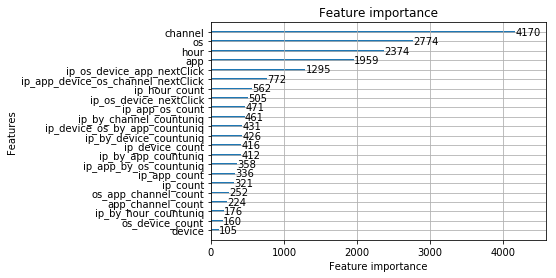

In [16]:
ax = lgb.plot_importance(booster, max_num_features=100)
plt.show()

In [17]:
plt.savefig('0505-2imp.png', dpi=600, bbox_inches='tight')

In [18]:
gc.collect()

156

In [19]:
with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load test data] done in 15 s


In [20]:
test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_df['click_time']= pd.to_datetime(testsup_df['click_time'])

In [21]:
# preditions=booster.predict(test_df[predictors].values)

print("Predicting the submission data...")

testsup_df['is_attributed'] = booster.predict(testsup_df[predictors], num_iteration=booster.best_iteration)

print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

Predicting the submission data...
projecting prediction onto test


In [22]:
test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

In [23]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,is_attributed
0,0,5744,9,1,3,107,2017-11-10 04:00:00,0.125770
1,1,119901,9,1,3,466,2017-11-10 04:00:00,0.013302
2,2,72287,21,1,19,128,2017-11-10 04:00:00,0.002406
3,3,78477,15,1,13,111,2017-11-10 04:00:00,0.042756
4,4,123080,12,1,13,328,2017-11-10 04:00:00,0.005191


In [ ]:
test_df.count()

click_id         18790469
ip               18790469
app              18790469
device           18790469
os               18790469
channel          18790469
click_time       18790469
is_attributed    18790469
dtype: int64

In [ ]:
print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('0505-2.csv', index=False)

print("All done...")

Writing the submission data into a csv file...
